# Color Discretization

### ColorDiscretizer demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
from utils.color_discretizer import ColorDiscretizer
from utils.color_utils import YUV_to_RGB, RGB_to_YUV
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
cd = ColorDiscretizer()
imdir = "../data/iccv09Data/images/"
cd.train(imdir, 30)

../utils/color_discretizer.py:71: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)


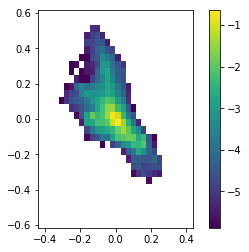

In [5]:
cd.plot_heatmap()

In [6]:
from matplotlib.pyplot import imread
from utils.color_utils import RGB_to_YUV

image = imread("../data/iccv09Data/images/0000051.jpg").astype(np.dtype("float32"))
YUVimage = RGB_to_YUV(image)
UVimage = YUVimage[:, :, 1:]
UVpixels = np.reshape(UVimage, newshape=[-1, 2])

In [7]:
cd.categorize(UVimage)

array([[160, 160, 160, ..., 160, 160, 160],
       [160, 160, 160, ..., 160, 160, 160],
       [160, 160, 160, ..., 160, 160, 160],
       ...,
       [ 93,  93,  93, ..., 108, 108, 108],
       [ 93,  93,  93, ..., 108, 108, 108],
       [ 93,  93,  93, ..., 108, 108, 108]])

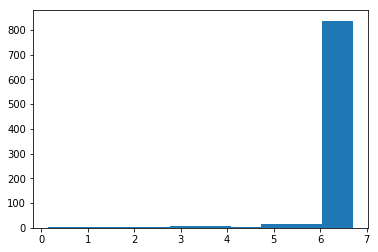

In [8]:
plt.hist(cd.weights.values())
plt.show()

In [9]:
unique, counts = np.unique(cd.categorize(UVimage), return_counts=True)

In [10]:
unique

array([ 93, 106, 107, 108, 120, 121, 122, 133, 134, 135, 147, 148, 159,
       160])

In [11]:
counts

array([ 7749,     9,  1559,  3439,  1404,  7737,    49,   639, 13804,
        1085, 19684,  4296,   192, 15154])

In [12]:
categories_distributions = np.abs(np.random.rand(4, 4, cd.n_categories))
cd.UVpixels_from_distribution(categories_distributions)

array([[[-0.03315402,  0.07698311],
        [-0.03066747,  0.06921814],
        [-0.03416319,  0.09534253],
        [-0.0403859 ,  0.0863239 ]],

       [[-0.01919941,  0.07071389],
        [-0.02707797,  0.0694897 ],
        [-0.0235898 ,  0.06949444],
        [-0.03442625,  0.08807495]],

       [[-0.03707806,  0.09540312],
        [-0.01893098,  0.06173505],
        [-0.03287281,  0.07017833],
        [-0.02915073,  0.07829343]],

       [[-0.02944605,  0.08040001],
        [-0.02273838,  0.07538133],
        [-0.03310046,  0.07626868],
        [-0.02822947,  0.08143073]]])

### L2 cost of categorizing

In [13]:
image = imread("../data/iccv09Data/images/0002136.jpg").astype(np.dtype("float32"))
YUVimage = RGB_to_YUV(image)
UVimage = YUVimage[:, :, 1:]
Yimage = YUVimage[:, :, :1]

In [14]:
pixels_categories = cd.categorize(UVimage)

pixel_categories_onehot = to_categorical(pixels_categories, num_classes=cd.n_categories)

reconstructed_UVimage = cd.UVpixels_from_distribution(pixel_categories_onehot)

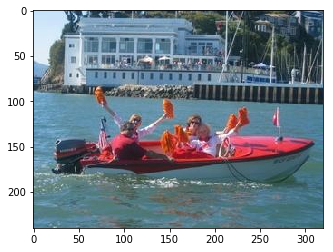

In [17]:
plt.imshow(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2))/255.)
plt.show()

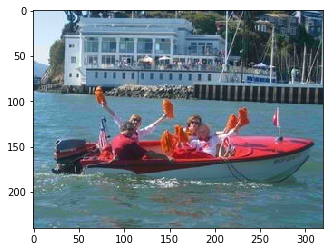

In [18]:
plt.imshow(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2)) / 255)
plt.show()

In [19]:
np.linalg.norm(reconstructed_UVimage - UVimage, axis = (0, 1)) / len(UVpixels) / np.std(UVpixels, axis = 0)

array([0.0007197 , 0.00104623])

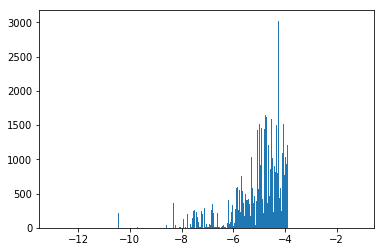

In [20]:
plt.hist(np.reshape(np.log(np.abs(reconstructed_UVimage - UVimage)), [-1, 1]), bins = 1000)
plt.show()

Note that sometimes, the return to RGB space goes over 255 or below 0, so we added a correction to the function.

In [23]:
print(np.max(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2),correction = False)))
print(np.min(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2),correction = False)))

255.00000000000006
-2.1282261841509484e-14


In [24]:
print(np.max(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2), correction = False)))
print(np.min(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2), correction = False)))

262.39922994021435
-7.434817488237526


### Thresholding out rare pixels

../utils/color_discretizer.py:71: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)


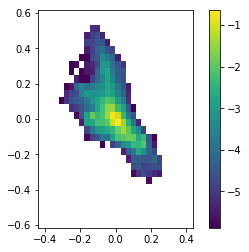

Remaining colors: 195


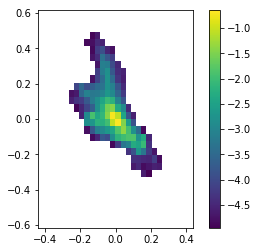

Remaining colors: 150


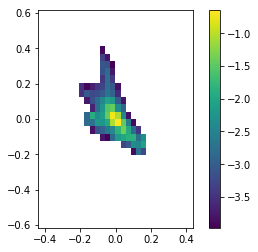

Remaining colors: 89


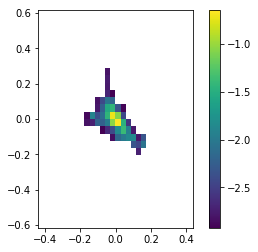

Remaining colors: 50


In [25]:
for threshold in [.000001, .00001, .0001, .001]:
    cd = ColorDiscretizer(threshold=threshold)
    imdir = "../data/iccv09Data/images/"
    cd.train(imdir, 30)
    cd.plot_heatmap()
    print("Remaining colors: {}".format(np.sum(cd.heatmap > cd.threshold)))